# Load packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# import os
# os.getcwd()

Mounted at /content/drive


In [2]:
!pip install scanpy
!pip install anndata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.5 MB/s eta 0:00:00


In [3]:
# !pip install scvi-tools@git+https://github.com/scverse/scvi-tools
!pip install scvi-tools

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.4/535.4 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import os, errno
import datetime
import uuid
import itertools
import yaml
import subprocess
import scipy.sparse as sp
from scipy.spatial.distance import squareform
from sklearn.decomposition import non_negative_factorization
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils import sparsefuncs
from scipy.cluster.hierarchy import leaves_list
import matplotlib.pyplot as plt
from multiprocessing import Pool
import scanpy as sc
%matplotlib inline
from scipy.io import mmread
from IPython.display import Image
import anndata
import seaborn as sns
import scvi
from scvi.external import MRVI as MrVI

# Upload Data

In [5]:
adata = sc.read_mtx(
    '/content/drive/My Drive/SHP2_project/Q510_screen/SHP2_count_all.mtx'
)

# adata = adata.T

In [6]:
genelist = pd.read_csv("/content/drive/My Drive/SHP2_project/Q510_screen/SHP2_rowData.csv",
                       sep=',',
                       header = 0)
genelist

adata.var_names = genelist["id"]

In [7]:
colData = pd.read_csv('/content/drive/My Drive/SHP2_project/Q510_screen/SHP2_colData.csv')

# Define conditions and corresponding group names
conditions = [
    colData['EGF_dose'] == 0,
    colData['EGF_dose'].isin([12.5, 25, 50]),
    colData['EGF_dose'].isin([100, 250, 500, 1000])
]
group_names = ['No EGF', 'Low', 'High']

# Create the 'EGF_dose_group' column using pd.cut
colData['EGF_dose_group'] = pd.cut(colData['EGF_dose'],
                                   bins=[-float('inf'), 1, 50, float('inf')],
                                   labels=group_names,
                                   include_lowest=True,
                                   right=False)

colData

,P7,P5,sample,Size_Factor,n_umi,cell_ID,RT,Lig,RT_well_position,timepoint,...,log10_dose,Cell,log10_umi,percent_mito,P7P5,num_genes_expressed,g1s_score,g2m_score,proliferation_index,EGF_dose_group
0,01B,A02,sciPlex,0.850808,1365,01B_A02_RT_BC_103_Lig_BC_24,RT_BC_103,Lig_BC_24,A07,96hr,...,1.09691,01B_A02_RT_BC_103_Lig_BC_24,3.135133,0.0,B02,1011,2.545809,1.209171,2.714976,Low
1,01B,A02,sciPlex,0.694982,1115,01B_A02_RT_BC_107_Lig_BC_13,RT_BC_107,Lig_BC_13,A11,96hr,...,1.69897,01B_A02_RT_BC_107_Lig_BC_13,3.047275,0.0,B02,893,1.910363,2.526615,2.905076,High
2,01B,A02,sciPlex,0.483683,776,01B_A02_RT_BC_107_Lig_BC_36,RT_BC_107,Lig_BC_36,A11,96hr,...,-inf,01B_A02_RT_BC_107_Lig_BC_36,2.889862,0.0,B02,696,2.428103,0.000000,2.428103,No EGF
3,01B,A02,sciPlex,0.201327,323,01B_A02_RT_BC_108_Lig_BC_40,RT_BC_108,Lig_BC_40,A12,96hr,...,-inf,01B_A02_RT_BC_108_Lig_BC_40,2.509203,0.0,B02,301,2.766392,2.391887,3.251740,No EGF
4,01B,A02,sciPlex,1.557633,2499,01B_A02_RT_BC_109_Lig_BC_80,RT_BC_109,Lig_BC_80,B01,24hr,...,1.09691,01B_A02_RT_BC_109_Lig_BC_80,3.397766,0.0,B02,1850,3.182710,2.716283,3.643777,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29331,12G,H07,sciPlex,2.185921,3507,12G_H07_RT_BC_97_Lig_BC_13,RT_BC_97,Lig_BC_13,A01,24hr,...,-inf,12G_H07_RT_BC_97_Lig_BC_13,3.544936,0.0,G07,2214,2.118610,2.403733,2.911479,No EGF
29332,12G,H07,sciPlex,1.394951,2238,12G_H07_RT_BC_97_Lig_BC_50,RT_BC_97,Lig_BC_50,A01,24hr,...,2.69897,12G_H07_RT_BC_97_Lig_BC_50,3.349860,0.0,G07,1742,2.100311,2.730296,3.113788,High
29333,12G,H07,sciPlex,0.481813,773,12G_H07_RT_BC_97_Lig_BC_54,RT_BC_97,Lig_BC_54,A01,24hr,...,-inf,12G_H07_RT_BC_97_Lig_BC_54,2.888179,0.0,G07,631,1.123466,3.749737,3.797406,No EGF
29334,12G,H07,sciPlex,33.774262,54186,12G_H07_RT_BC_97_Lig_BC_91,RT_BC_97,Lig_BC_91,A01,24hr,...,3.00000,12G_H07_RT_BC_97_Lig_BC_91,4.733887,0.0,G07,10653,2.284756,2.876854,3.280220,High


In [8]:
colData.columns.unique()

Index(['P7', 'P5', 'sample', 'Size_Factor', 'n_umi', 'cell_ID', 'RT', 'Lig',
       'RT_well_position', 'timepoint', 'SHP2_mut', 'EGF_dose', 'hash_plate',
       'hash_well', 'hash_umis', 'proportion', 'total_hash_umis_per_cell',
       'rank', 'top_to_second_best_ratio', 'log10_dose', 'Cell', 'log10_umi',
       'percent_mito', 'P7P5', 'num_genes_expressed', 'g1s_score', 'g2m_score',
       'proliferation_index', 'EGF_dose_group'],
      dtype='object')

In [9]:

# Timepoint annotations
timepoint = colData['timepoint']
adata.obs['timepoint'] = timepoint.values.astype('str')

# Mutant annotations
SHP2_mut = colData['SHP2_mut']
adata.obs['SHP2_mut'] = SHP2_mut.values.astype('str')

# EGF Dose annotations
EGF_dose = colData['EGF_dose']
adata.obs['EGF_dose'] = EGF_dose.values.astype('str')

# EGF Dose Group annotations
EGF_dose_group = colData['EGF_dose_group']
adata.obs['EGF_dose_group'] = EGF_dose_group.values.astype('str')

# Replicate
replicate = colData['hash_plate']
adata.obs['replicate'] = replicate.values.astype('str')

# Display anndata summary
adata

AnnData object with n_obs × n_vars = 29336 × 8822
    obs: 'timepoint', 'SHP2_mut', 'EGF_dose', 'EGF_dose_group', 'replicate'

In [10]:
adata.obs['time_mut_dose'] = adata.obs['timepoint']+'_'+adata.obs['SHP2_mut']+'_'+adata.obs['EGF_dose_group']
adata.obs['time_mut_dose']

,time_mut_dose
0,96hr_Q510E_Low
1,96hr_Q510E_High
2,96hr_Q510L_No EGF
3,96hr_Q510K_No EGF
4,24hr_Q510E_Low
...,...
29331,24hr_Q510P_No EGF
29332,24hr_Q510K_High
29333,24hr_Q510E_No EGF
29334,24hr_Q510L_High


In [11]:
adata.obs['time_mut_dose'].value_counts()

,count
time_mut_dose,
96hr_Q506P_High,1375
24hr_Q506P_High,1357
96hr_Q510E_High,1211
96hr_Q510L_High,1156
96hr_Q510H_High,1044
24hr_Q510E_High,1018
96hr_Q510K_High,982
24hr_Q510K_High,957
96hr_T507K_High,939


# Feature selection

In [12]:
hvg_union = set()
for c in np.unique(adata.obs['timepoint']):
    for d in np.unique(adata.obs['SHP2_mut']):
        adata_temp = adata[(adata.obs['timepoint'] == c) & (adata.obs['SHP2_mut'] == d)]
        sc.pp.log1p(adata_temp)
        sc.pp.highly_variable_genes(adata_temp,
                                    flavor='seurat',
                                    n_top_genes=100,
                                    inplace=True,
                                    subset=True)
        hvg_union = hvg_union.union(set(adata_temp.var_names))
print(len(hvg_union))

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:413: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:413: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:413: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:413: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:413: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:413: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/

809


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:413: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
adata = adata[:,list(hvg_union)]
adata

View of AnnData object with n_obs × n_vars = 29336 × 809
    obs: 'timepoint', 'SHP2_mut', 'EGF_dose', 'EGF_dose_group', 'replicate', 'time_mut_dose'

In [14]:
hvg_list = list(hvg_union)
df = pd.DataFrame(hvg_list, columns=['genes'])
df.to_csv('/content/drive/My Drive/SHP2_project/Q510_screen/hvg_union_top_100.csv', index=False)

# Subset for cell line

In [15]:
# Split the dataset: single cell line and random sets of cells from each drug-dose facet

adata_mini = adata[(adata.obs['timepoint'] == '24hr') &
                   (adata.obs['EGF_dose_group'] == 'No EGF')]
adata_mini

View of AnnData object with n_obs × n_vars = 2160 × 809
    obs: 'timepoint', 'SHP2_mut', 'EGF_dose', 'EGF_dose_group', 'replicate', 'time_mut_dose'

# Fit the model

In [16]:
batch_key = 'replicate'
sample_key = 'time_mut_dose'
labels_key = None

MrVI.setup_anndata(adata_mini,
                   sample_key=sample_key,
                   batch_key=batch_key)

/usr/local/lib/python3.11/dist-packages/scvi/external/mrvi/_model.py:183: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["_indices"] = np.arange(adata.n_obs).astype(int)


In [17]:
model = MrVI(adata_mini)
model.train(accelerator='cpu',
            early_stopping=True,
            max_epochs=400)

INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


<ipython-input-17-2459c4deab74>:2: UserWarning: Running mrVI with Jax version larger 0.4.35 can cause performance issues
  model.train(accelerator='cpu',
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:369: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


Monitored metric elbo_validation did not improve in the last 15 records. Best score: 522.938. Signaling Trainer to stop.


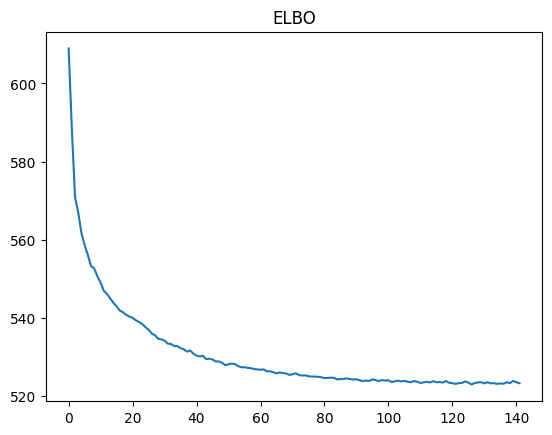

In [18]:
plt.plot(model.history["elbo_validation"])
plt.title("ELBO")
plt.show()

In [19]:

model.save(dir_path='/content/drive/My Drive/SHP2_project/Q510_screen/SHP2_Q510_MrVI_24hr_NoEGF_model_time-mut-dosegroup_attention-100hvg',
           overwrite=True,
           save_anndata=True)


In [20]:
# reloading data if restarting session
adata = sc.read_h5ad('/content/drive/My Drive/SHP2_project/Q510_screen/SHP2_Q510_MrVI_24hr_NoEGF_model_time-mut-dosegroup_attention-100hvg/adata.h5ad')

In [ ]:
# reloading data if restarting session
'''
model = MrVI.load(
    dir_path='/content/drive/My Drive/SHP2_project/Q510_screen/SHP2_Q510_MrVI_24hr_NoEGF_model_time-mut-dosegroup_attention/',
    adata=adata,
    accelerator='cpu',
    device=1
)
model

INFO     File /content/drive/My                                                                                    
         Drive/SHP2_project/Q510_screen/SHP2_Q510_MrVI_24hr_NoEGF_model_time-mut-dosegroup_attention/model.pt      
         already downloaded                                                                                        
INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


/usr/local/lib/python3.11/dist-packages/scvi/module/base/_base_module.py:723: UserWarning: Running mrVI with Jax version larger 0.4.35 can cause performance issues
  model.train(max_steps=1)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


Training status: Trained

# Get latent representations

In [21]:
# from scvi.model.utils import mde

u = model.get_latent_representation(give_z=False)
adata.obsm["u"] = u
sc.pp.neighbors(adata, use_rep="u")
sc.tl.umap(adata, min_dist=0.3)

# u_mde = mde(u)
# adata.obsm["u_mde"] = u_mde
# sc.pl.embedding(adata, basis="u_mde", color="SHP2_mut", size=10)

100%|██████████| 17/17 [00:09<00:00,  1.77it/s]


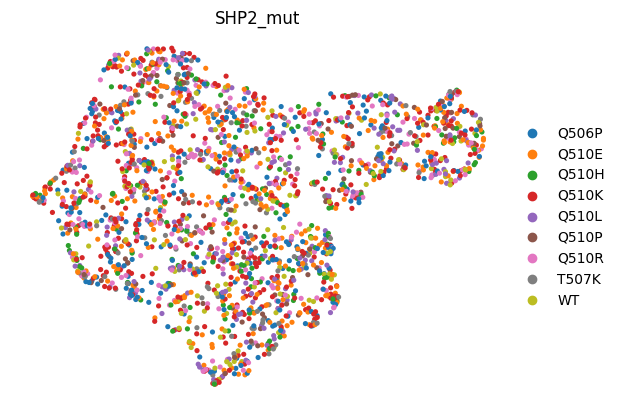

In [22]:
# sc.pl.embedding(adata, basis="u_mde", color="PDCL", size=10)
sc.pl.umap(
    adata,
    color=["SHP2_mut"],
    frameon=False,
    ncols=1,
)

In [23]:
# save sample-sample dist matrix
np.savetxt("/content/drive/My Drive/SHP2_project/Q510_screen/SHP2_Q510_MrVI_24hr_NoEGF_u_factor.csv", u, delimiter=",")

In [24]:
z = model.get_latent_representation(give_z=True)
adata.obsm["z"] = z
sc.pp.neighbors(adata, use_rep="z")
sc.tl.umap(adata, min_dist=0.3)

100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


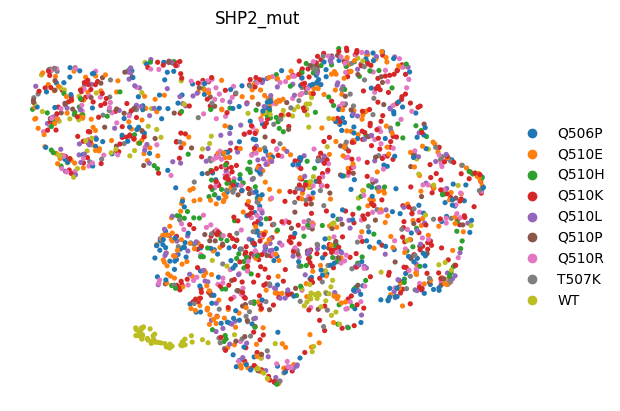

In [25]:
sc.pl.umap(
    adata,
    color=["SHP2_mut"],
    frameon=False,
    ncols=1,
)

In [26]:
# save sample-sample dist matrix
np.savetxt("/content/drive/My Drive/SHP2_project/Q510_screen/SHP2_Q510_MrVI_24hr_NoEGF_z_factor.csv", z, delimiter=",")

# Cell distances

In [ ]:
# Compute local sample representations
cell_reps = model.get_local_sample_representation(adata)

100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


In [27]:
import xarray as xr

batch_key = 'replicate'
sample_key = 'time_mut_dose'
labels_key = None

cell_dists = model.get_local_sample_distances(
        adata,
        use_mean=True,
        normalize_distances=False,
        keep_cell=False,
        groupby=sample_key,
    )

# save dists
cell_dists.to_netcdf("/content/drive/My Drive/SHP2_project/Q510_screen/SHP2_Q510_24hr_NoEGF_cell_dists_namedosesample_attention.nc")

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


In [ ]:
'''
import xarray as xr

# load dists
cell_dists = xr.open_dataset("/content/drive/My Drive/PhD/Research/RG Factor Analysis/MrVI/bt112_cell_dists_namedosesample_attention_morecells.nc")
cell_dists
'''

'\nimport xarray as xr\n\n# load dists\ncell_dists = xr.open_dataset("/content/drive/My Drive/PhD/Research/RG Factor Analysis/MrVI/bt112_cell_dists_namedosesample_attention_morecells.nc")\ncell_dists\n'

In [28]:
# create a DataFrame for mean sample-sample distances across all cells

drug_dist_df = pd.DataFrame(
        cell_dists['time_mut_dose'].mean(axis=0),
        columns = cell_dists['sample_x'].values,
        index = cell_dists['sample_x'].values
)
drug_dist_df
drug_dist_df.to_csv('/content/drive/My Drive/SHP2_project/Q510_screen/SHP2_Q510_24hr_NoEGF_mrvi_dist_df_attention.csv')

In [ ]:
# save sample-sample dist matrix
# drug_dist_df.to_csv('/content/drive/My Drive/SHP2_project/SHP2_allcells_mrvi_dist_df_attention.csv')

In [ ]:
# Printing single cell distances to csv
import xarray as xr

batch_key = 'replicate'
sample_key = 'time_mut_dose'
labels_key = None

cell_dists = model.get_local_sample_distances(
        adata,
        # use_mean=False,
        # normalize_distances=False,
        keep_cell=True,
        groupby=sample_key,
    )

# save dists
# cell_dists.to_netcdf("/content/drive/My Drive/SHP2_project/Q510_screen/SHP2_Q510_cell_dists_namedosesample_attention_singlecell.nc")

100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


In [ ]:
cell_dists

<xarray.Dataset> Size: 721kB
Dimensions:             (cell_name: 2160, sample_x: 9, sample_y: 9,
                         time_mut_dose_name: 9)
Coordinates:
  * cell_name           (cell_name) object 17kB '5' '6' '11' ... '29331' '29333'
  * sample_x            (sample_x) object 72B '24hr_Q506P_No EGF' ... '24hr_W...
  * sample_y            (sample_y) object 72B '24hr_Q506P_No EGF' ... '24hr_W...
  * time_mut_dose_name  (time_mut_dose_name) <U17 612B '24hr_Q510K_No EGF' .....
Data variables:
    cell                (cell_name, sample_x, sample_y) float32 700kB 0.0 ......
    time_mut_dose       (time_mut_dose_name, sample_x, sample_y) float32 3kB ...

In [ ]:
adata.obs['sample_key'] = adata.obs['time_mut_dose']

In [ ]:
# Avg distance from other samples per cell: vector to quantify sample effect heterogeneity within cell populations
# of interest e.g. response modules or drug-dose conditions
cell_dists = cell_dists['cell']

dist_vec = []
hpf_state_anno = []
target_anno = []

for i in range(cell_dists.shape[0]):
    hpf_state_temp = adata.obs['sample_key'].iloc[i]
    hpf_state_temp_index = np.where(cell_dists['sample_x'].to_numpy() == hpf_state_temp)[0][0]
    vec_temp = cell_dists[i,hpf_state_temp_index,:].to_numpy()
    dist_vec.append(vec_temp)
    hpf_state_anno.append([hpf_state_temp]*len(vec_temp))
    target_anno.append(cell_dists[i,:]['sample_y'].values.tolist())

dist_vec = np.concatenate(dist_vec,axis=0)
hpf_state_anno = np.concatenate(hpf_state_anno,axis=0)
target_anno = np.concatenate(target_anno,axis=0)

In [ ]:
# HPF state-specific distribution of distances

counterfactual_df = pd.DataFrame(dist_vec,
                                 columns=['Counterfactual Distance'],
                                 index=hpf_state_anno
                                )
counterfactual_df['sample_group'] = hpf_state_anno
counterfactual_df['target_group'] = target_anno

counterfactual_df
counterfactual_df.to_csv('/content/drive/My Drive/SHP2_project/Q510_screen/SHP2_Q510_24hr_NoEGF_cell_dists_namedosesample_attention_singlecell.csv')

# Sample-sample dist matrix

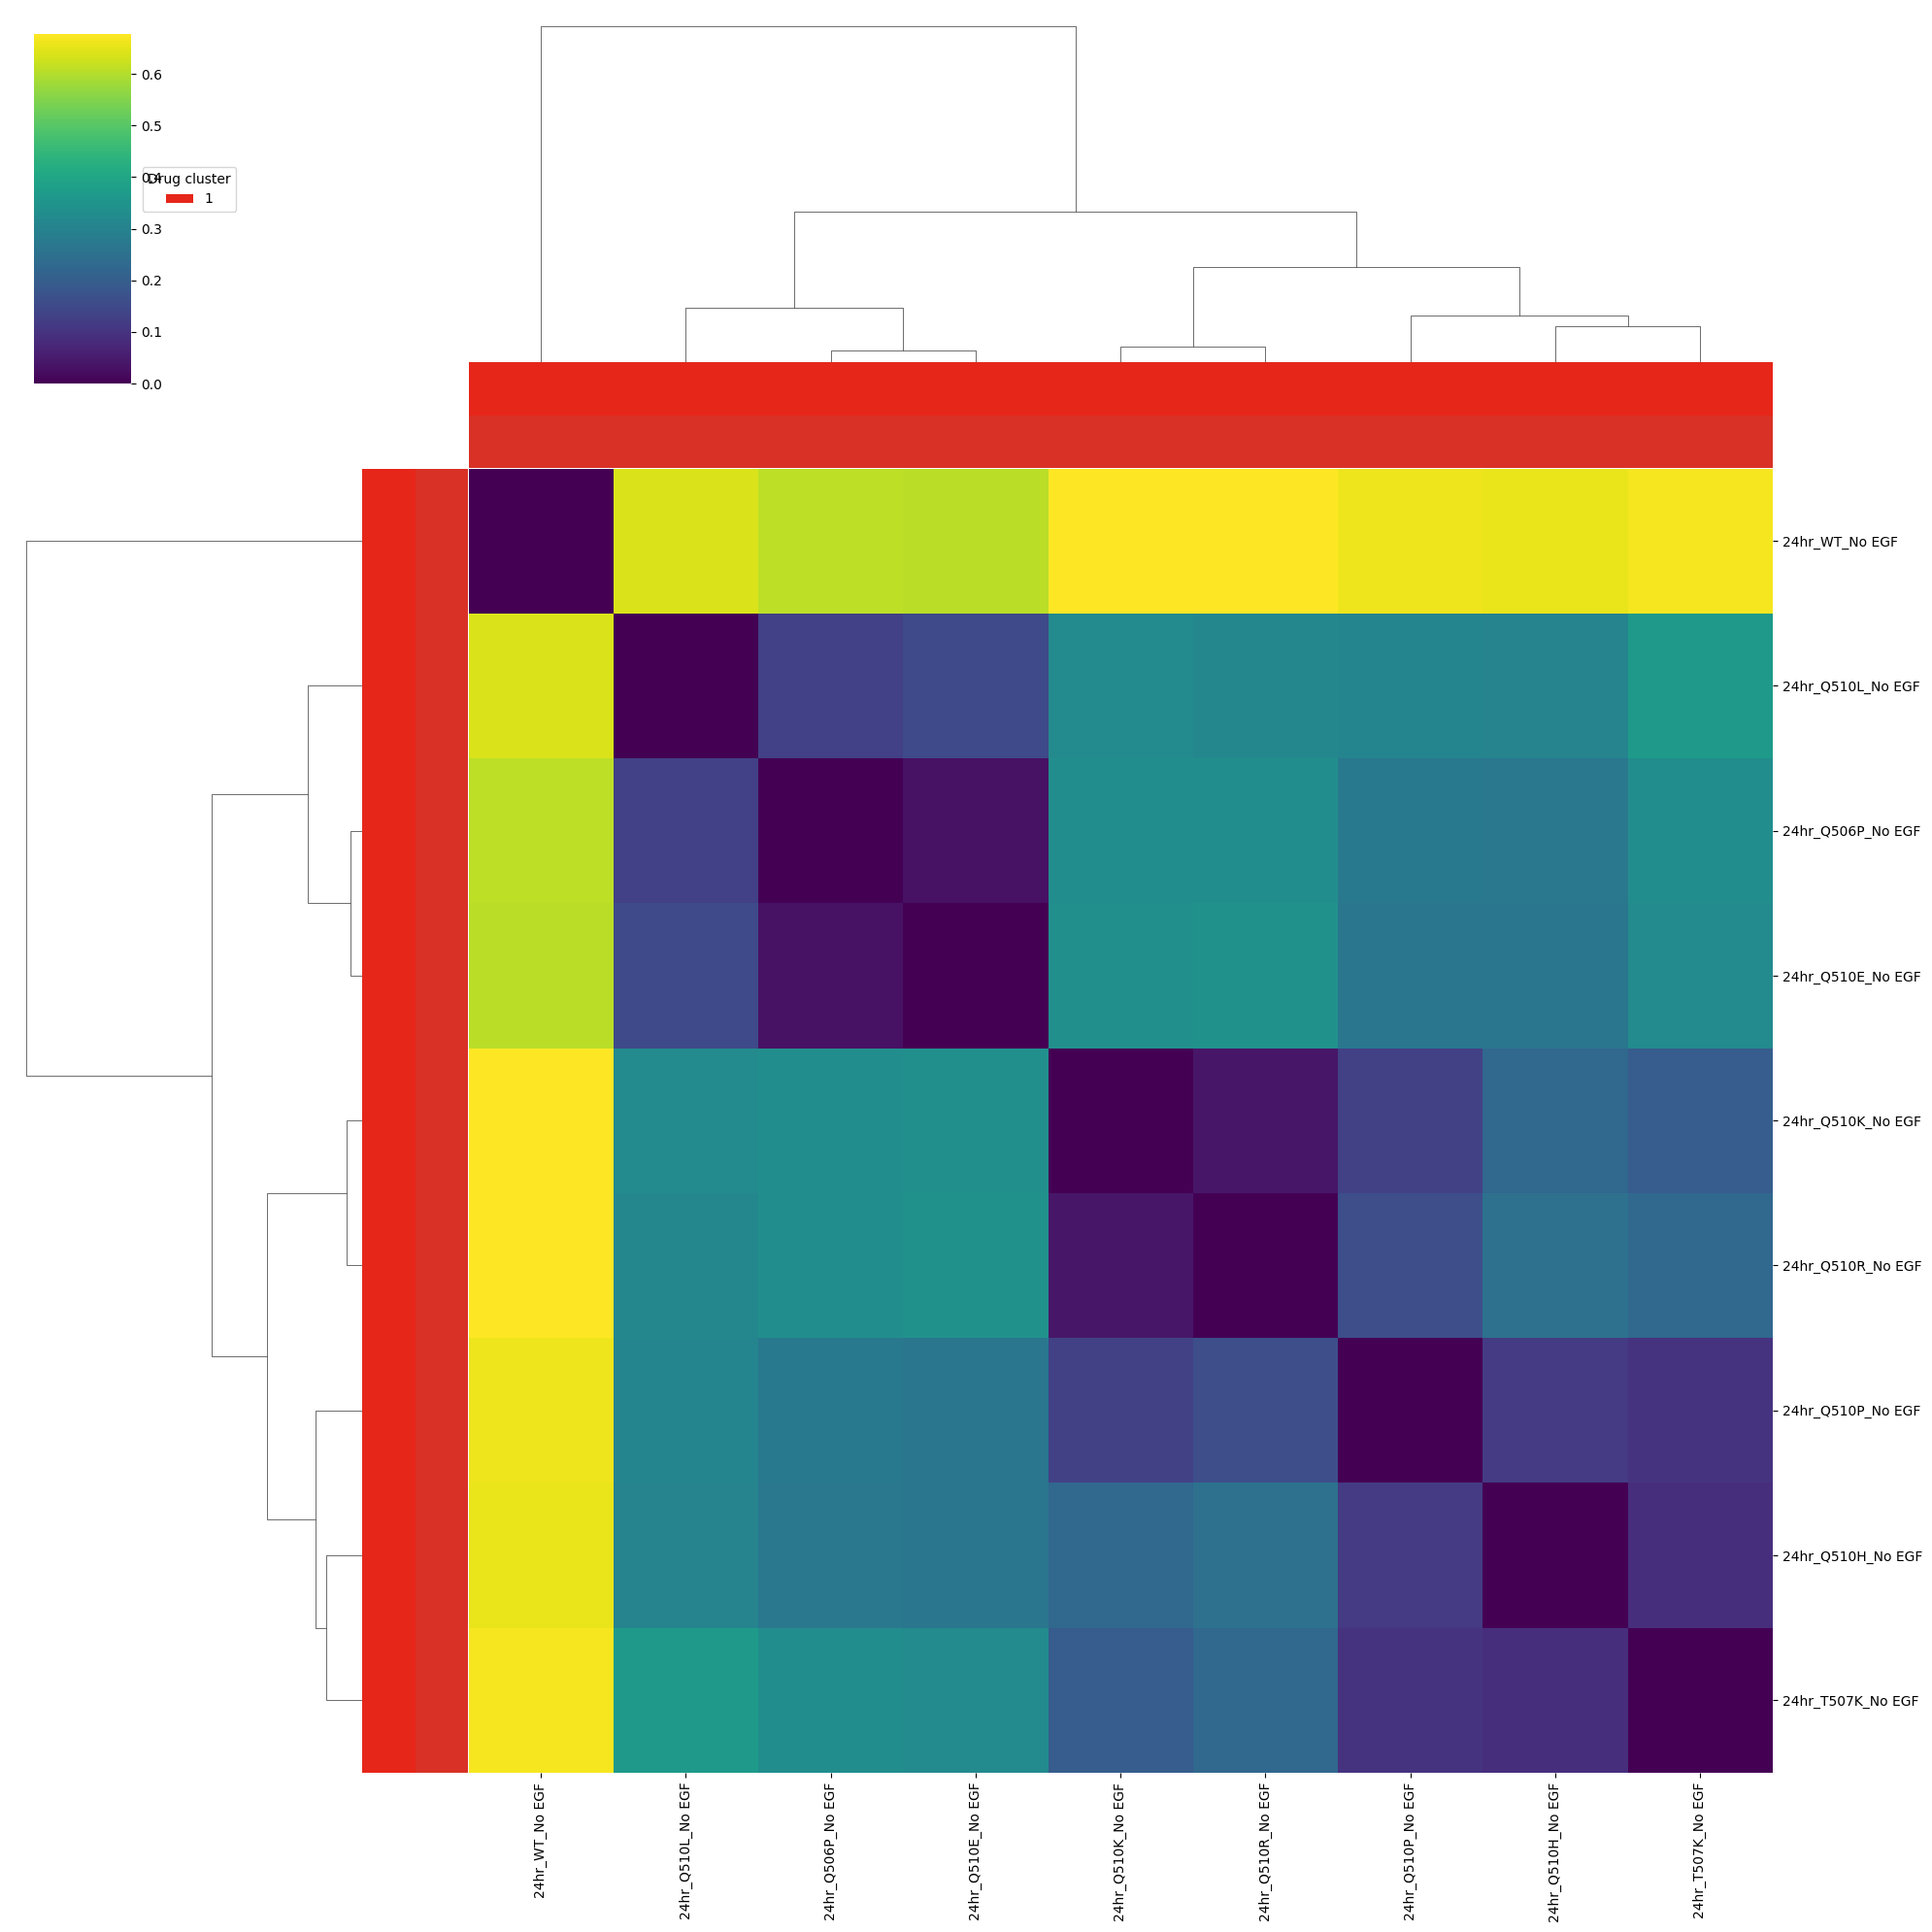

In [29]:
# HEATMAP: Sample-Sample dist matrix

from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster

cluster_method = 'complete'

row_linkage = hierarchy.linkage(
    distance.pdist(drug_dist_df),
    method=cluster_method
)

col_linkage = row_linkage

row_col_labels = fcluster(col_linkage, t=28, criterion='distance')
# row_col_labels = np.array([i[0] for i in drug_cluster_labels.values.tolist()])
lut = dict(zip(set(row_col_labels), sns.hls_palette(len(set(row_col_labels)), l=0.5, s=0.8)))
row_col = pd.DataFrame(row_col_labels)[0].map(lut)

labels2 = np.array([i[-3:] for i in drug_dist_df.columns.values])
lut2 = dict(zip(set(labels2), sns.hls_palette(len(set(labels2)), l=0.5, s=0.7)))
row_col2 = pd.DataFrame(labels2)[0].map(lut2)

g = sns.clustermap(drug_dist_df,
                   row_linkage=row_linkage,
                   col_linkage=col_linkage,
                   method=cluster_method,
                   row_colors = [row_col, row_col2],
                   col_colors = [row_col, row_col2],
                   annot=False,
                   figsize=(20, 20),
                   cmap='viridis',
                   yticklabels=True,xticklabels=True)
                   # vmin=0,vmax=2)

from matplotlib.pyplot import gcf

for label in np.unique(row_col_labels):
    g.ax_col_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
l1 = g.ax_col_dendrogram.legend(title='Drug cluster', loc="center",
                               bbox_to_anchor=(0.1, 0.9), bbox_transform=gcf().transFigure,
                               ncol=2)

# for label in np.unique(labels2):
#     g.ax_row_dendrogram.bar(0, 0, color=lut2[label], label=label, linewidth=0)
# l2 = g.ax_row_dendrogram.legend(title='Dose', loc="center",
#                              bbox_to_anchor=(0.12, 0.9), bbox_transform=gcf().transFigure)

plt.show()

# Covariate-specific DE test

In [ ]:
model.sample_info

,timepoint,SHP2_mut,EGF_dose,EGF_dose_group,replicate,time_mut_dose,_indices,_scvi_batch,_scvi_labels
_scvi_sample,,,,,,,,,
0,24hr,Q506P,50.0,High,1,24hr_Q506P_High,39,0,0
1,24hr,Q506P,12.5,Low,2,24hr_Q506P_Low,40,1,0
2,24hr,Q506P,0.0,No EGF,1,24hr_Q506P_No EGF,82,0,0
3,24hr,Q510E,100.0,High,1,24hr_Q510E_High,35,0,0
4,24hr,Q510E,12.5,Low,1,24hr_Q510E_Low,4,0,0
5,24hr,Q510E,0.0,No EGF,2,24hr_Q510E_No EGF,26,1,0
6,24hr,Q510H,250.0,High,1,24hr_Q510H_High,34,0,0
7,24hr,Q510H,12.5,Low,1,24hr_Q510H_Low,95,0,0
8,24hr,Q510H,0.0,No EGF,1,24hr_Q510H_No EGF,94,0,0


In [ ]:
# Create the SHP2_Q510KRH column in model.sample_info
model.sample_info["SHP2_Q510KRH"] = model.sample_info['SHP2_mut'].apply(
    lambda x: 'Q510KRH' if x in ['Q510K', 'Q510R', 'Q510H', "T507K", "Q510L"] else ('WT' if x == 'WT' else 'Other')
)

# Filter based on both criteria
filtered_indices = model.sample_info[
    (model.sample_info['EGF_dose_group'] == "High") &
    (model.sample_info["SHP2_Q510KRH"].isin(["WT", "Q510KRH"]))
]

# filtered_time_mut_dose = filtered_indices["_scvi_sample"].tolist()

# filtered_indices now contains the desired _scvi_sample indices
print(filtered_indices)

             timepoint SHP2_mut EGF_dose EGF_dose_group replicate  \
_scvi_sample                                                        
6                 24hr    Q510H    250.0           High         1   
9                 24hr    Q510K    100.0           High         1   
12                24hr    Q510L    500.0           High         2   
18                24hr    Q510R     50.0           High         1   
21                24hr    T507K    250.0           High         1   
24                24hr       WT    500.0           High         1   
33                96hr    Q510H    500.0           High         2   
36                96hr    Q510K   1000.0           High         2   
39                96hr    Q510L    250.0           High         2   
45                96hr    Q510R    100.0           High         2   
48                96hr    T507K    250.0           High         1   
51                96hr       WT   1000.0           High         2   

                time_mut_dose  _i

In [ ]:
model.sample_info["SHP2_Q510KRH"]

,SHP2_Q510KRH
_scvi_sample,
0,Other
1,Other
2,Other
3,Other
4,Other
5,Other
6,Q510KRH
7,Q510KRH
8,Q510KRH


In [ ]:
sample_cov_keys = ["SHP2_Q510KRH"]  # Replace with your sample covariate of interest

model.sample_info["SHP2_Q510KRH"] = model.sample_info["SHP2_Q510KRH"].astype('category')
model.sample_info["SHP2_Q510KRH"] = model.sample_info["SHP2_Q510KRH"].cat.reorder_categories(
    ["WT", "Q510KRH", "Other"]
)  # Reorder categories such that the coefficient corresponds to Q510 mutant


# Perform differential expression on the filtered data
de_res_Q510_KRH = model.differential_expression(
    adata=adata_filtered,
    sample_cov_keys=sample_cov_keys,
    store_lfc=True,
    sample_subset=filtered_time_mut_dose
)


100%|██████████| 230/230 [13:14<00:00,  3.45s/it]


In [ ]:
# SAVE THE MULTIVARIATE DE ANALYSIS RESULTS
import pickle

with open('/content/drive/My Drive/SHP2_project/Q510_screen/SHP2_24hr_Q510_DE_test.pkl', 'wb') as outp:
    pickle.dump(de_res_Q510_KRH, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
Q510_LFC=de_res_Q510_KRH.sel(covariate="SHP2_Q510KRH_Q510KRH").lfc.to_pandas()

Q510_LFC.to_csv('/content/drive/My Drive/SHP2_project/Q510_screen/SHP2_Q510_DE_test_LFC.csv')

In [ ]:
adata.obs["Q510KRH_DE_eff_size"] = de_res_Q510_KRH.effect_size.sel(covariate="SHP2_Q510KRH_Q510KRH").values
sc.pl.umap(
    adata,
    color=["SHP2_mut", "Q510KRH_DE_eff_size"],
    frameon=False,
    ncols=1,
    vmax=np.quantile(de_res_Q510_KRH.effect_size.values, 0.95),
    cmap="viridis",
)

KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

In [ ]:
sample_cov_keys = ["SHP2_Q510"]  # Replace with your sample covariate of interest
model.sample_info["SHP2_Q510"] = model.sample_info['SHP2_mut'].apply(lambda x: 'Q510' if x in ['Q510K', 'Q510R', 'Q510H', "Q510E", "Q510L", "Q510P"] else 'Other')
model.sample_info["SHP2_Q510"] = model.sample_info["SHP2_Q510"].astype('category')
model.sample_info["SHP2_Q510"] = model.sample_info["SHP2_Q510"].cat.reorder_categories(
    ["Other", "Q510"]
)  # Reorder categories such that the coefficient corresponds to Q510 mutant
de_res = model.differential_expression(
    sample_cov_keys=sample_cov_keys,
    store_lfc=True
)

100%|██████████| 230/230 [1:02:54<00:00, 16.41s/it]


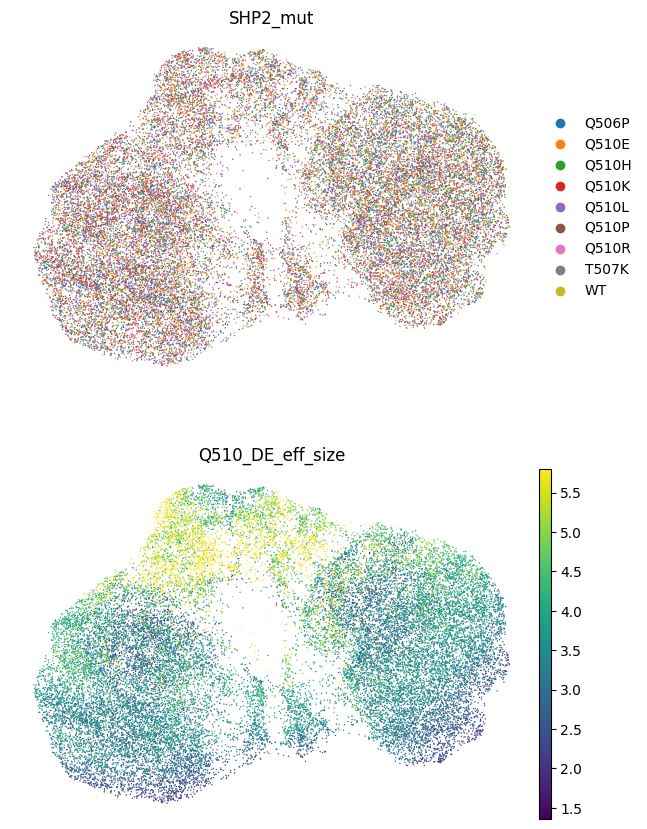

In [ ]:
adata.obs["Q510_DE_eff_size"] = de_res.effect_size.sel(covariate="SHP2_Q510_Q510").values
sc.pl.umap(
    adata,
    color=["SHP2_mut", "Q510_DE_eff_size"],
    frameon=False,
    ncols=1,
    vmax=np.quantile(de_res.effect_size.values, 0.95),
    cmap="viridis",
)

In [ ]:
# SAVE THE MULTIVARIATE DE ANALYSIS RESULTS
import pickle

with open('/content/drive/My Drive/SHP2_project/Q510_screen/SHP2_24hr_Q510_DE_test.pkl', 'wb') as outp:
    pickle.dump(de_res, outp, pickle.HIGHEST_PROTOCOL)

de_res

<xarray.Dataset> Size: 834MB
Dimensions:      (cell_name: 29336, covariate: 1, latent_dim: 30, gene: 2358)
Coordinates:
  * cell_name    (cell_name) object 235kB '0' '1' '2' ... '29334' '29335'
  * covariate    (covariate) <U14 56B 'SHP2_Q510_Q510'
  * latent_dim   (latent_dim) int64 240B 0 1 2 3 4 5 6 ... 23 24 25 26 27 28 29
  * gene         (gene) object 19kB 'ENSG00000071462.11' ... 'ENSG00000043355...
Data variables:
    beta         (cell_name, covariate, latent_dim) float32 4MB -0.00305 ... ...
    effect_size  (cell_name, covariate) float32 117kB 5.27 3.927 ... 3.483 2.824
    pvalue       (cell_name, covariate) float32 117kB 1.0 1.0 1.0 ... 1.0 1.0
    padj         (cell_name, covariate) float32 117kB 1.0 1.0 1.0 ... 1.0 1.0
    lfc          (covariate, cell_name, gene) float32 277MB 0.0002777 ... 0.0...
    lfc_std      (covariate, cell_name, gene) float32 277MB 0.001103 ... 0.00...
    pde          (covariate, cell_name, gene) float32 277MB 0.0 0.0 ... 0.0 0.0

In [ ]:
Q510_LFC=de_res.sel(covariate="SHP2_Q510_Q510").lfc.to_pandas()

Q510_LFC.to_csv('/content/drive/My Drive/SHP2_project/Q510_screen/SHP2_24hr_Q510_DE_test_LFC.csv')